Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
%matplotlib inline

# Part 1: The seven scientists

This example is due to [MacKay 2003, exercise 22.15] and [Lee & Wagenmaker 2013, section 4.2].

Suppose seven scientists all go and perform the same experiment, each collecting a measurement $x_i$ for $i = 1,\dots,7$, of an underlying physical value $\mu$. 
 
These scientists are varyingly good at their job, and while we can assume each scientist would estimate $\mu$ correctly _on average_, some of them may have much more error in their measurements than others.

They come back with the following seven observations:


In [3]:
measurements = torch.FloatTensor([-27.020, 3.570, 8.191, 9.898, 9.603, 9.945, 10.056])

plt.bar(np.arange(1,8), measurements) # , "o")
plt.xlabel("Which scientist")
plt.ylabel("Recorded measurement $x_i$");

From looking at the plot, clearly one scientist does not know what they are doing (and some of the others are probably a little suspect too)!


### A model for the data

In this exercise we will suppose that there is "scientist-specific" standard deviation $\sigma_i$, which describes how accurately each of them might perform the experiment:

$$\begin{align}
x_i &\sim \mathrm{Normal}(\mu, \sigma_i^2).
\end{align}$$

Scientists with low $\sigma_i$ produce good estimates of $x$, whereas scientists with high $\sigma_i$ might have wildly inaccurate estimates. However, we don't know _which_ scientists are good -- and we only have one observation from each!

We can ask two questions:

* What is the "real" value of $\mu$?
* What are the values of $\sigma_i$ for each scientists?



### Bayesian inference approach

You will have to choose priors for the mean $\mu$ of the measurements, and for the error standard deviation $\sigma\_i$ for each of the $i$ scientists. A good starting point is

$$\begin{align}
\mu &\sim \mathrm{Normal}(0, \alpha^2) \\
\sigma_i &\sim \mathrm{Exponential}(\beta)
\end{align}$$

where $\alpha=50$ and $\beta=0.5$. This is a prior distribution with mean 2 that places diminishing probability density on larger values of $\sigma_i$:


In [4]:
plt.fill_between(np.linspace(0.01,10,100), 0.0, 
                 dist.Exponential(rate=0.5).log_prob(torch.linspace(0.01,10,100)).exp(), 
                 edgecolor='k');
plt.xlabel("$\sigma$")
plt.ylabel("$p(\sigma)$")
plt.title("Exponential distribution");

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
C:\Users\44774\AppData\Local\Temp\ipykernel_26352\1639954671.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("$\sigma$")
C:\Users\44774\AppData\Local\Temp\ipykernel_26352\1639954671.py:5: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("$p(\sigma)$")


# TASK #1 (3 points): Define the model

Given $\alpha=50, \beta=0.5$, and the measurements $x$ above, write a function to compute the unnormalized log density

$$\log p(\mu, x_1,\dots,x_7, \sigma_1,\dots, \sigma_7 | \alpha, \beta)$$

In [5]:
def log_joint(mu, sigma, alpha=50, beta=0.5):
    """
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian prior on mu. Default to 50
    beta  : scalar, rate of exponential prior on sigma_i. Default to 0.5

    OUTPUT:
    log_joint: the log probability log p(mu, sigma, x | alpha, beta), scalar
    
    NOTE: For inputs where sigma <= 0, please return negative infinity!

    """
    assert mu.ndim == 0
    assert sigma.shape == (7,)
    
    # YOUR CODE HERE
    # Check if sigma <= 0 and return -inf if so
    if torch.any(sigma <= 0):
        return -torch.inf
    
    # Prior on mu: Gaussian(0,alpha^2)
    prior_mu = dist.Normal(0, alpha).log_prob(mu)
    
    # Prior on sigma: Exponential(beta)
    prior_sigma = dist.Exponential(beta).log_prob(sigma).sum()
    
    # Likelihood: x_i ~ Normal(mu, sigma_i^2)
    likelihood = dist.Normal(mu, sigma).log_prob(measurements).sum()
    
    # Log joint probability
    log_joint = prior_mu + prior_sigma + likelihood
    
    return log_joint

#### Ignore the following cells. 

They consist of "hidden" test cases, and are used by the grading system.

In [6]:
# (GRADING)

In [7]:
# (GRADING)

# TASK #2 (5 points): Implement an MCMC sampler

Your second task is to implement an MCMC algorithm to sample from the posterior distribution

$$p(\mu, \sigma | x, \alpha, \beta).$$

To do this, you need to implement two functions:

* `get_mcmc_proposal`: this takes in current values of $\mu$ and $\sigma$, and returns pytorch `Distribution` objects (i.e., `torch.distributions.Distribution`, here in-scope as `dist.Distribution`) that will propose a next value given the current value, $q(\mu' | \mu, \dots)$ and $q(\sigma' | \sigma, \dots)$. It is **your choice** what sort of distribution to use here! Just make sure that whatever you propose works well in your MCMC algorithm.

* `mcmc_step`: this takes in current values of $\mu$ and $\sigma$, and runs a single Metropolis-Hastings step:
  1. sample candidate values from the proposal distribution you defined
  2. compute an acceptance probability, and either accept or reject
  3. return $\mu, \sigma$

In [8]:
def get_mcmc_proposal(mu, sigma):
    """
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0

    OUTPUT:
    q_mu    : instance of Distribution class, that defines a proposal for mu
    q_sigma : instance of Distribution class, that defines a proposal for sigma
    """
    
    # YOUR CODE HERE
    # Define a Gaussian proposal distribution for mu, with a small standard deviation
    q_mu = dist.Normal(loc=mu, scale=0.1)
    
    # Define a log-normal proposal distribution for sigma (log-normal ensures sigma > 0)
    q_sigma = dist.LogNormal(loc=torch.log(sigma), scale=0.1)
    
    return q_mu, q_sigma

### Quick self-check!

If your `get_mcmc_proposal` has the correct function signature, all the following assertions should be true:

In [9]:
q_mu, q_sigma = get_mcmc_proposal(torch.tensor(9.0), torch.ones(7))
assert isinstance(q_mu, dist.Distribution)
assert isinstance(q_sigma, dist.Distribution)
assert q_mu.sample().shape == ()
assert q_sigma.sample().shape == (7,)
del q_mu, q_sigma

In [10]:
def mcmc_step(mu, sigma, alpha=50, beta=0.5):
    """
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian prior on mu. Default to 50
    beta  : scalar, rate of exponential prior on sigma_i. Default to 0.5

    OUTPUT:
    mu       : the next value of mu in the MCMC chain
    sigma    : the next value of sigma in the MCMC chain
    accepted : a boolean value, indicating whether the proposal was accepted

    """
    
    accepted = False
    q_mu, q_sigma = get_mcmc_proposal(mu, sigma) # Get proposal distribution for 'mu' and 'sigma' from our last function
    
    # YOUR CODE HERE
    # Sample candidate values for mu and sigma from the proposal distributions
    mu_prime = q_mu.sample()
    sigma_prime = q_sigma.sample()
    
    # Compute log joint probability for current values (mu, sigma)
    log_p_current = log_joint(mu, sigma, alpha, beta)
    
    # Compute log joint probability for proposed values (mu', sigma')
    log_p_proposed = log_joint(mu_prime, sigma_prime, alpha, beta)
    
    # Compute the proposal probabilities q(mu'|mu) and q(sigma'|sigma)
    # Proposal: log(q(mu',sigma'|mu, sigma) ) = log(q(mu'|mu)) + log(q(sigma'|sigma))
    log_q_proposed_given_current = q_mu.log_prob(mu_prime) + q_sigma.log_prob(sigma_prime).sum()
    
    # Compute the reverse proposal probabilities q(mu|mu') and q(sigma|sigma')
    reverse_q_mu = dist.Normal(loc=mu_prime, scale=0.15)
    reverse_q_sigma = dist.LogNormal(loc=torch.log(sigma_prime), scale=0.15)
    
    # Reversed Proposal: log(q(mu,sigma|mu', sigma') ) = log(q(mu|mu')) + log(q(sigma|sigma'))
    log_q_current_given_proposed = reverse_q_mu.log_prob(mu) + reverse_q_sigma.log_prob(sigma).sum()
    
    # Compute the acceptance probability 
    # log_acceptance_ratio = log(p(mu', sigma') * q(mu|mu') * q(sigma|sigma')) - log(p(mu, sigma, x) * q(mu'|mu) * q(sigma'|sigma))
    log_acceptance_ratio = (log_p_proposed + log_q_current_given_proposed) - (log_p_current + log_q_proposed_given_current)
    
    # define accpetance ratio A
    A = min(torch.tensor(1.0), torch.exp(log_acceptance_ratio))
    
    # Acceptance step: accept the proposal with probability min(1, exp(log_acceptance_ratio))
    if torch.rand(1).item() < A:
        mu = mu_prime
        sigma = sigma_prime
        accepted = True
    
    return mu, sigma, accepted

## Running MCMC

We've supplied the outer loop for you -- it will call and execute your `mcmc_step` function. You should *not* need to edit it!

You do need to fill in the function `algo_parameters`, though, which just returns the total number of iterations you decide to run the MCMC chain, and the number of samples to discard as "burnin".

In [11]:
def run_mcmc(N_iters, mu_init, sigma_init):
    """ Run an MCMC algorithm for a fixed number of iterations """
    
    mu_chain = [mu_init]
    sigma_chain = [sigma_init]
    N_accepted = 0
    for _ in range(N_iters):
        mu, sigma, accepted = mcmc_step(mu_chain[-1], sigma_chain[-1])
        mu_chain.append(mu)
        sigma_chain.append(sigma)
        N_accepted += accepted
    
    return torch.stack(mu_chain), torch.stack(sigma_chain), N_accepted / N_iters

In [12]:
def algo_parameters():
    """ TODO: set these to appropriate values:
    
    OUTPUT:
    N_samples : total number of MCMC steps
    N_burnin  : number of initial steps to discard
    """
    
    # YOUR CODE HERE
    
    N_samples = 10000 # Total number of MCMC steps
    N_burnin = 3000 # Set burn-in 
    
    return N_samples, N_burnin

## Initialize, run, and display diagnostics

The following code initializes the MCMC sampler, executes it for the number of iterations you specified, and then plots a handful of diagnostics.

Use these diagnostics to decide whether or not you have done this properly! Take some time to try to interpret the results, and feel free to play around with the plots a bit.

In [13]:
mu_init = measurements.mean()
sigma_init = torch.ones(7)

N_samples, N_burnin = algo_parameters()

mu_chain, sigma_chain, accepted = run_mcmc(N_samples, mu_init, sigma_init)
print("acceptance rate:", accepted)

acceptance rate: 0.3335


<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
C:\Users\44774\AppData\Local\Temp\ipykernel_26352\1474348908.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")
C:\Users\44774\AppData\Local\Temp\ipykernel_26352\1474348908.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$\mu$")


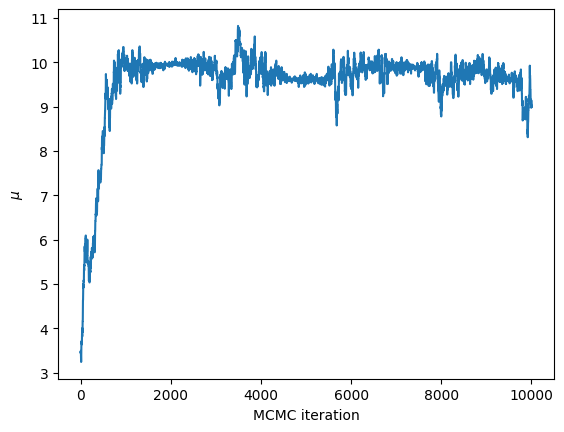

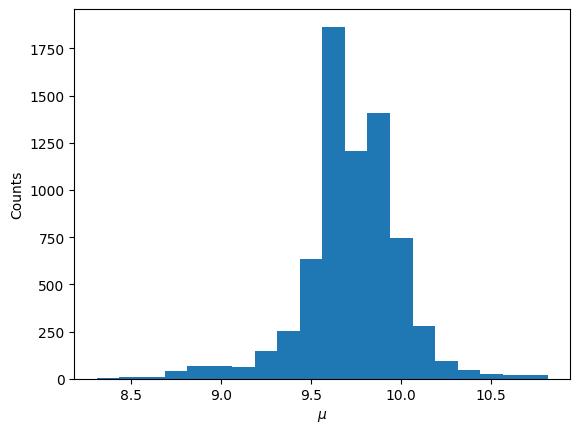

In [29]:
plt.plot(mu_chain);
plt.xlabel("MCMC iteration");
plt.ylabel("$\mu$")
plt.figure();
plt.hist(mu_chain[N_burnin:].numpy(), bins=20);
plt.xlabel("$\mu$")
plt.ylabel("Counts");
plt.show()

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
C:\Users\44774\AppData\Local\Temp\ipykernel_26352\1447813369.py:5: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("$\sigma_i$");


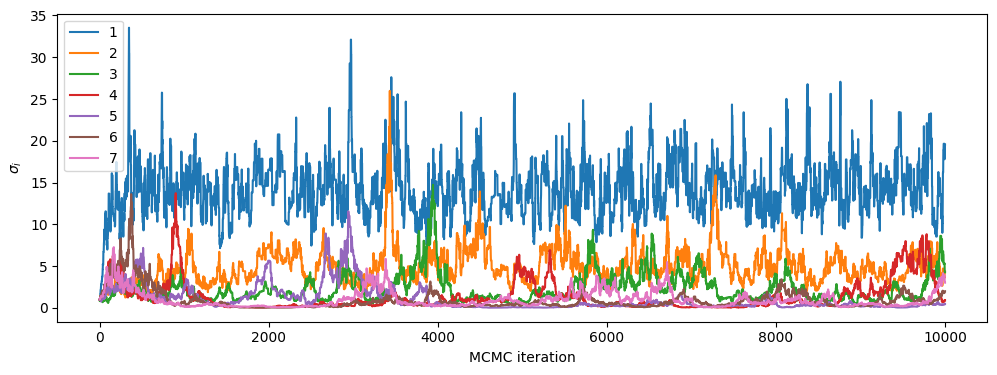

In [30]:
plt.figure(figsize=(12,4));
plt.plot(sigma_chain)
plt.legend(range(1,8));
plt.xlabel("MCMC iteration")
plt.ylabel("$\sigma_i$");
plt.show()

In [31]:
plt.boxplot(sigma_chain[N_burnin:], positions=np.arange(1, 8));
plt.xlabel("Which scientist")
plt.ylabel("Estimated measurement std $\sigma_i$");

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
C:\Users\44774\AppData\Local\Temp\ipykernel_26352\33331944.py:3: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("Estimated measurement std $\sigma_i$");


# TASK #3 (2 points): Estimate posterior expectations

We're specifically interested in using the samples to answer the following:

1. What is the expected value of $\mu$, i.e., $\mathbb{E}[\mu ]$, under the posterior distribution?
2. What is the posterior probability that $\mu$ is less than 9, i.e. $\Pr(\mu < 9.0)$?

Both of these questions can be answered by using samples from your MCMC chain.

In [17]:
def estimate_E_mu(mu_chain, sigma_chain, N_burnin):
    """ Estimate E[mu] 
    
    INPUTS:
    mu_chain    : sequence of MCMC samples of mu
    sigma_chain : sequence of MCMC samples of sigma 
    N_burnin    : number of initial MCMC samples to discard as burnin 
    
    OUTPUTS:
    mu : expected value of mu (scalar)
    """
    
    # Discard burn-in samples
    mu_post_burnin = mu_chain[N_burnin:]
    
    # Calculate the mean of the remaining mu_chain (i.e. E[mu])
    mu = mu_post_burnin.mean().item()
    
    return mu
    
def estimate_pr_mu_lt_9(mu_chain, sigma_chain, N_burnin):
    """ Estimate the posterior probability that mu is less than 9, i.e. Pr(mu < 9) 
    
    INPUTS:
    mu_chain    : sequence of MCMC samples of mu
    sigma_chain : sequence of MCMC samples of sigma 
    N_burnin    : number of initial MCMC samples to discard as burnin 
    
    OUTPUTS:
    estimate : estimate of Pr(mu < 9), a scalar
    """
    
    # Discard burn-in samples
    mu_post_burnin = mu_chain[N_burnin:]
    
    # Calculate the probability that mu is less than 9
    pr_mu_lt_9 = (mu_post_burnin < 9).float().mean().item()
    
    return pr_mu_lt_9

In [18]:
print("E[mu] = %0.4f" % estimate_E_mu(mu_chain, sigma_chain, N_burnin))
print("Pr(mu < 9) = %0.4f" % estimate_pr_mu_lt_9(mu_chain, sigma_chain, N_burnin))

E[mu] = 9.7223
Pr(mu < 9) = 0.0249


# SHORT ANSWER SECTION (4 points)

Please answer the following 2 questions, for up to two points each:

1. Describe your choices of MCMC proposal distributions. How did you select them? How do you know they are "good"?
2. In your `mcmc_step`, we consider 8 random variables, $\mu, \sigma_1, \dots, \sigma_7$, but you probably implemented this using a single accept-reject step (i.e., you propose new values for all random variables, and then jointly accept all of them, or not). Suppose someone suggested instead proposing for each of these variables one-at-a-time sequentially, including a separate accept-reject step after each. Might this be a good idea, and why or why not?

##### Question 1
**For the proposal distribution, I made the following choices:**

- For $\mu$: I used a **normal distribution** centered at the current value of $\mu$ with a small standard deviation (0.1), i.e., $q(\mu' | \mu) \sim \text{Normal}(\mu, 0.1)$.
- For $\sigma_i$: I used a **log-normal distribution** to ensure that the proposed $\sigma_i$ values remain positive, i.e., $q(\sigma' | \sigma) \sim \text{LogNormal}(\log(\sigma), 0.1)$.

**Why I selected these distributions:**
- **Normal proposal for $\mu$**: The normal distribution is a common choice for continuous parameters, as it allows exploration of values near the current position. The small standard deviation of 0.1 was chosen to ensure that the proposed moves are reasonably close to the current value, helping the MCMC chain mix well without excessive rejections.
- **Log-normal proposal for $\sigma_i$**: Since $\sigma_i$ represents standard deviations, they must be positive. The log-normal distribution ensures positivity while allowing for smooth updates around the current $\sigma_i$. The small standard deviation for the log-normal was also chosen to keep proposals near the current value and prevent large jumps.

**How do I know they are "good"?**
- The **acceptance rate** of approximately **30%** suggests that the proposal distributions are well-tuned. An acceptance rate between 20% and 40% is typically considered ideal, depending on the dimensionality of the problem. The 30% acceptance rate implies that the proposed moves are accepted in a way that's enough to explore the posterior, but not so often that the chain is moving too slowly.
- The MCMC **diagnostics** (trace plots and posterior histograms) show that the chain has converged and is mixing well, meaning the proposal distributions are effective for exploring the posterior distribution.

##### Question 2
The idea of proposing for each variable (i.e., $\mu, \sigma_1, \dots, \sigma_7$) **sequentially** with a separate accept-reject step for each has both potential benefits and drawbacks.

**Why it could be a good idea**:
- **Better mixing in higher-dimensional spaces**: When proposing updates to multiple variables simultaneously, the joint proposal might have a very low acceptance rate because the combined move could take the chain far from the current point in high-dimensional space. By proposing for one variable at a time, you ensure that each step in the chain is evaluated independently, which can improve the **mixing** of the chain and allow more gradual exploration of the posterior.
- **Higher acceptance rates**: Proposing moves for individual variables typically leads to higher acceptance rates because the updates are smaller and more localized. This could improve the exploration of the posterior, especially if some variables are more sensitive than others.

**Why it might not be a good idea**:
- **Slower convergence**: Sequential proposals can slow down the convergence of the MCMC algorithm because each step is small. The chain may take longer to explore the space fully, especially in cases where the variables are strongly correlated. A single joint proposal can potentially move the chain faster through correlated parameter spaces.
- **Increased computation**: Proposing for each variable individually adds computational overhead since each proposal involves calculating the likelihood and acceptance probability multiple times (once for each variable). This increases the computational cost per iteration.

**Conclusion**:
The choice between joint proposals and sequential proposals depends on the **structure of the problem**:
- **Joint proposals** are generally more efficient if the parameters are not strongly correlated and the joint acceptance rate is reasonable (as in our case).
- **Sequential proposals** might be beneficial if the parameters exhibit strong correlations or if the joint acceptance rate is too low, but it comes at the cost of slower convergence and increased computation.


#### Ignore the following cells. They are used by the grading system.

In [19]:
# (GRADING)

In [20]:
# (GRADING)

In [21]:
# (GRADING)

In [22]:
# (GRADING)

In [23]:
# (GRADING)

# EXTRA CREDIT TASK #4 (2 points): Estimate $\alpha$ and $\beta$

Did we choose the hyperparameters $\alpha$ and $\beta$ well? Or were these poor selections?

One way of checking whether $\alpha$ and $\beta$ are set well is by computing a marginal likelihood estimate, i.e. estimating $p(x | \alpha, \beta)$ for different choices of $\alpha, \beta$.

However, a different option is to *also* perform Bayesian inference over $\alpha$ and $\beta$! To do this, we need to do three things:

1. Define a prior $p(\alpha, \beta)$
2. Define MCMC proposals $q(\alpha' | \alpha)$ and $q(\beta' | \beta)$
3. Update the MCMC algorithm itself to also sample $\alpha, \beta$.

To do this, this involves targeting the joint probability distribution

$$p(x,\mu,\sigma,\alpha,\beta) = p(x | \mu, \sigma)p(\mu | \alpha)p(\sigma | \beta)p(\alpha)p(\beta).$$

You can write your MCMC algorithm so that it alternates between doing updates on $\mu, \sigma$ (using your existing `mcmc_step` function) and doing updates on $\alpha, \beta$ (using a new `mcmc_step_hyperparams` function).

To do this you need to implement two things:

1. `log_prior_alpha_beta`: given $\alpha,\beta$, return $\log p(\alpha, \beta)$. You are free to define whatever sort of prior you think is appropriate.
2. `mcmc_step_hyperparams`: do a single MCMC step (including accept / reject) to update $\alpha, \beta$.

These will then be called by the `run_mcmc_bonus` function, below.

In [24]:
def log_prior_alpha_beta(alpha, beta):
    """
    Define a prior distribution on alpha, beta, and return its log probability
    
    INPUT:
    alpha : scalar, standard deviation of Gaussian distribution on mu
    beta  : scalar, rate of exponential distribution on sigma_i

    OUTPUT:
    log_prob : scalar, `log p(alpha, beta)`
    
    """
    # Gamma prior on alpha (shape=1, rate=1)
    prior_alpha = dist.Gamma(1, 1).log_prob(alpha)
    
    # Gamma prior on beta (shape=2, rate=1)
    prior_beta = dist.Gamma(2, 1).log_prob(beta)
    
    # Sum the log probabilities to get the joint log prior
    log_prob = prior_alpha + prior_beta
    
    return log_prob

In [25]:
def mcmc_step_hyperparams(mu, sigma, alpha, beta):
    """
    Run an MCMC step on alpha and beta
    
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian distribution on mu
    beta  : scalar, rate of exponential distribution on sigma_i

    OUTPUT:
    alpha    : the next value of alpha in the MCMC chain
    beta     : the next value of beta in the MCMC chain
    accepted : a boolean value, indicating whether the proposal was accepted
    
    """
    
    # Define proposal distributions for alpha and beta (Log-normal)
    q_alpha = dist.LogNormal(torch.log(alpha), 0.1)
    q_beta = dist.LogNormal(torch.log(beta), 0.1)
    
    # Sample new proposed values for alpha and beta
    alpha_prime = q_alpha.sample()
    beta_prime = q_beta.sample()
    
    # Compute log posterior for current (alpha, beta)
    log_p_current = log_joint(mu, sigma, alpha, beta) + log_prior_alpha_beta(alpha, beta)
    
    # Compute log posterior for proposed (alpha', beta')
    log_p_proposed = log_joint(mu, sigma, alpha_prime, beta_prime) + log_prior_alpha_beta(alpha_prime, beta_prime)
    
    # Compute acceptance probability (log scale)
    log_acceptance_ratio = log_p_proposed - log_p_current
    
    A = min(torch.tensor(1.0), torch.exp(log_acceptance_ratio))
    
    # Acceptance stepL accept if log(U) < log_acceptance_ratio
    if torch.rand(1).item() < A:
        alpha = alpha_prime
        beta = beta_prime
        accepted = True
    else:
        accepted = False
    
    return alpha, beta, accepted

### Run this MCMC algorithm, and plot the results.

What do you think?

1. Are these results qualitatively different?
2. Were the original choices of $\alpha, \beta$ reasonable?
3. How sensitive are these results to $\alpha, \beta$? To $p(\alpha, \beta)$?

In [26]:
def run_mcmc_bonus(N_iters, mu_init, sigma_init, alpha_init, beta_init):
    """ Run an MCMC algorithm for a fixed number of iterations.
    
    This also runs MCMC on "hyperparameters" alpha and beta.
    
    """
    
    mu_chain = [mu_init]
    sigma_chain = [sigma_init]
    alpha_chain = [alpha_init]
    beta_chain = [beta_init]
    for _ in range(N_iters):
        alpha, beta, accepted = mcmc_step_hyperparams(mu_chain[-1], sigma_chain[-1], alpha_chain[-1], beta_chain[-1])
        alpha_chain.append(alpha)
        beta_chain.append(beta)

        mu, sigma, accepted = mcmc_step(mu_chain[-1], sigma_chain[-1], alpha_chain[-1], beta_chain[-1])
        mu_chain.append(mu)
        sigma_chain.append(sigma)
    
    return torch.stack(mu_chain), torch.stack(sigma_chain), torch.stack(alpha_chain), torch.stack(beta_chain)

In [27]:
new_mu_chain, new_sigma_chain, alpha_chain, beta_chain = run_mcmc_bonus(N_samples, mu_chain[-1], sigma_chain[-1], torch.tensor(50.0), torch.tensor(0.5))

KeyboardInterrupt: 

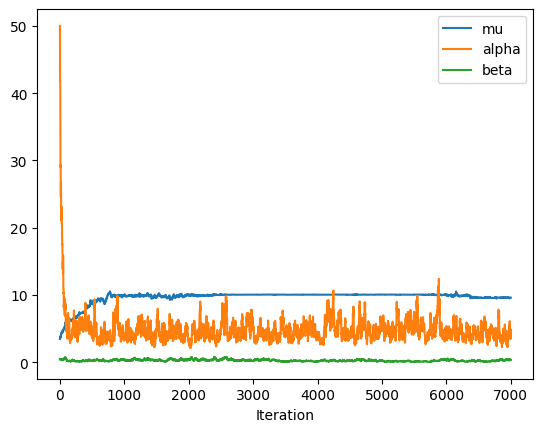

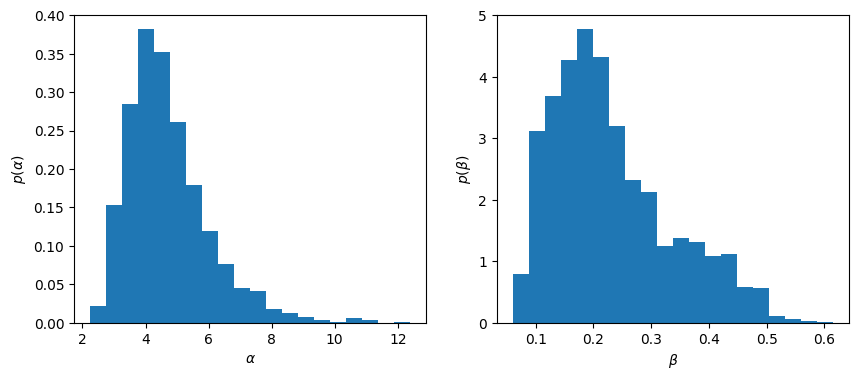

In [ ]:
plt.plot(mu_chain)
plt.plot(alpha_chain);
plt.plot(beta_chain);
plt.legend(['mu', 'alpha', 'beta']);
plt.xlabel("Iteration");
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.hist(alpha_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\\alpha$")
plt.ylabel("$p(\\alpha)$")
plt.subplot(122)
plt.hist(beta_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\\beta$")
plt.ylabel("$p(\\beta)$");

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
C:\Users\44774\AppData\Local\Temp\ipykernel_28992\882005571.py:2: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$\mu$")
C:\Users\44774\AppData\Local\Temp\ipykernel_28992\882005571.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$p(\mu)$");


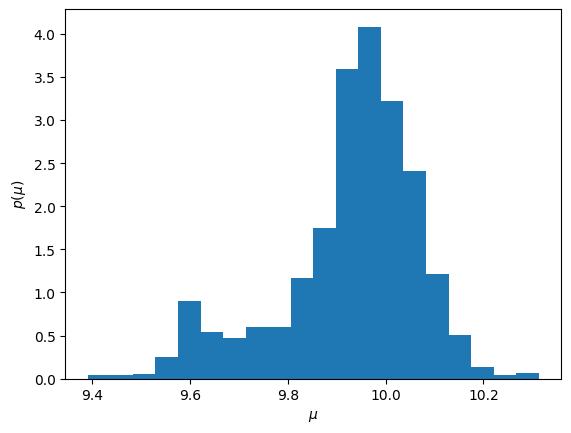

In [ ]:
plt.hist(new_mu_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\mu$")
plt.ylabel("$p(\mu)$");

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
C:\Users\44774\AppData\Local\Temp\ipykernel_28992\1331496043.py:3: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("Estimated measurement std $\sigma_i$");


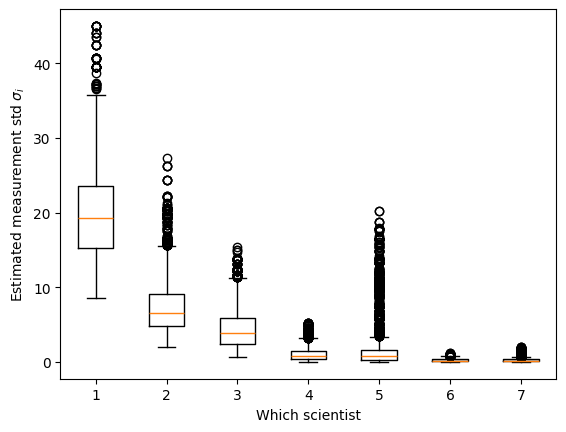

In [ ]:
plt.boxplot(new_sigma_chain[N_burnin:], positions=np.arange(1, 8));
plt.xlabel("Which scientist")
plt.ylabel("Estimated measurement std $\sigma_i$");

In [ ]:
# (GRADING)

In [ ]:
# (GRADING)